# [POC] Foetal Health Classification w Keras

This dataset contains **2126** records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Suspect
3. Pathological

The dataset is obtained from [Kaggle.com](https://www.kaggle.com/), an online machine learning community.

Link to the dataset is [Here](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download)

## 1. Importing Packages


In [4]:
# General Python imports
import os
import gc
import time
import tqdm
import random

import numpy as np
import pandas as pd

for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        FILE_PATH = os.path.join(dirname, filename)
        print(FILE_PATH)

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

import warnings
warnings.filterwarnings('ignore')     

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense

input/fetal_health.csv


## 2. Configs

In [5]:
SEED = 123
random.seed(SEED)

TEST_SIZE = 0.20
VAL_SIZE = 0.15

EPOCHS = 100
BATCH_SIZE = 4

## 3. Dataset

In [6]:
data = pd.read_csv(FILE_PATH)

In [7]:
data

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


### 3.1 Class Imbalance

In a dataset where the output target values are unbalanced, there exists a class imbalance issue, wherein one class vastly outnumbers the others. This significant disproportion can skew the training of a model towards the larger class, resulting in a biased model that struggles to effectively learn from the minority classes.

Consequently, the model may prioritize predicting the dominant class to achieve high accuracy, without truly capturing the nuances of the data. This imbalance can hinder the model's ability to generalise well to unseen data and may lead to misleading conclusions

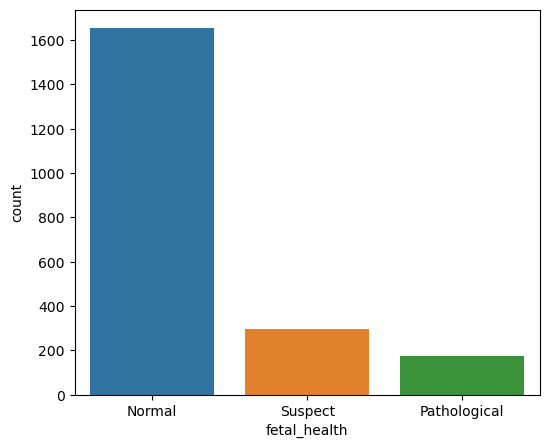

In [11]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(x=data['fetal_health'])

class_labels = ['Normal', 'Suspect', 'Pathological']
ax.set_xticklabels(class_labels)
plt.show()

In [17]:
label = LabelEncoder()
label.fit(data['fetal_health'])
data['fetal_health'] = label.transform(data['fetal_health'])

print("Unique values after transformation:")
print(data['fetal_health'].unique())

Unique values after transformation:
[1 0 2]


### 3.2 Data Split

* Before we can start training our models, we need to **randomly** partition our dataset into training data and testing data.
* Remember that we are trying to make a model that can predict fraudulence of data points that the model has never seen. It would be unwise to measure the accuracy of the model using the same data it trained on.

In [21]:
print(f"Data Split:\nTest size: {TEST_SIZE}\nVali size: {VAL_SIZE}\n")

X = data.drop(columns='fetal_health')
y = data['fetal_health']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=TEST_SIZE,
                                                    random_state=SEED)

print(f"X_train: ({X_train.shape}), y_train: ({y_train.shape})")
print(f"X_test: ({X_test.shape}), y_test: ({y_test.shape})")

Data Split:
Test size: 0.2
Vali size: 0.15

X_train: ((1700, 21)), y_train: ((1700,))
X_test: ((426, 21)), y_test: ((426,))


In [23]:
n_features = len(X_train.columns)
n_features

21

### 3.3 Obtain Class Weights

In [28]:
# Calculate class weights from sklearn
class_weight_array = class_weight.compute_class_weight('balanced',
                                                       classes=np.unique(y_train),
                                                       y=y_train)
print(f"Class weights: {class_weight_array}\n")

# Class weights as dictionary for Keras
keys = [0, 1, 2]
class_weight_dict = dict(zip(keys, class_weight_array.T))
print(f"Class weights dict: {class_weight_dict}")

Class weights: [0.42831948 2.40112994 4.01891253]

Class weights dict: {0: 0.42831947593852354, 1: 2.401129943502825, 2: 4.0189125295508275}


### 3.4 Convert to arrays for Keras operation

In [29]:
X_train = X_train.values
X_test = X_test.values

y_train = y_train.values
y_test = y_test.values

## 4. Model

### 4.1 Build the Model